In [2]:
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Obtaining data

In [3]:
now_time = datetime.now()
start_time = datetime(now_time.year - 5, now_time.month , now_time.day)
print(start_time, now_time)

data = pdr.get_data_yahoo('AAPL', start_time, now_time)
data

2018-01-18 00:00:00 2023-01-18 04:10:56.537176
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-18,44.842499,45.025002,44.562500,44.814999,42.614563,124773600
2018-01-19,44.652500,44.895000,44.352501,44.615002,42.424389,129700400
2018-01-22,44.325001,44.445000,44.150002,44.250000,42.077305,108434400
2018-01-23,44.325001,44.860001,44.205002,44.259998,42.086811,130756400
2018-01-24,44.312500,44.325001,43.299999,43.555000,41.416447,204420400
...,...,...,...,...,...,...
2023-01-10,130.259995,131.259995,128.119995,130.729996,130.729996,63896200
2023-01-11,131.250000,133.509995,130.460007,133.490005,133.490005,69458900
2023-01-12,133.880005,134.259995,131.440002,133.410004,133.410004,71379600


In [4]:
# Check for missing values
data.isnull().sum()/len(data)

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

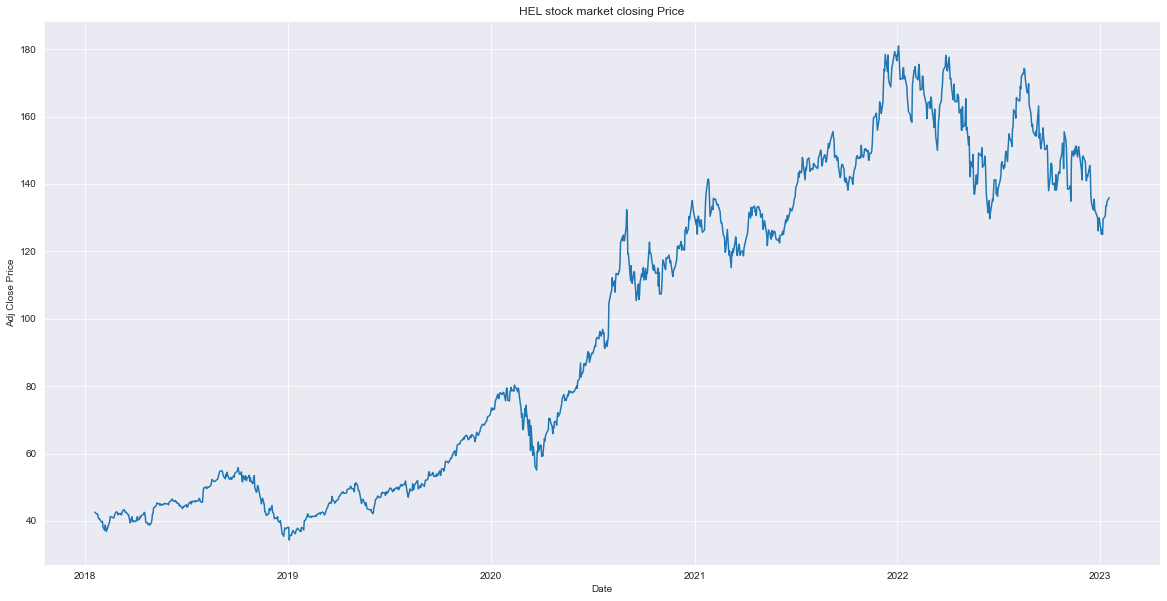

In [5]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('HEL stock market closing Price')
plt.plot(data['Adj Close'])

# Checking the stationarity

In [6]:
def test_adf(timeseries):
    
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()
    
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(moving_average, color='red', label='Rolling Mean')
    plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Results of dickey fuller test')
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'Critical value {key}'] = value
    print(output)
    

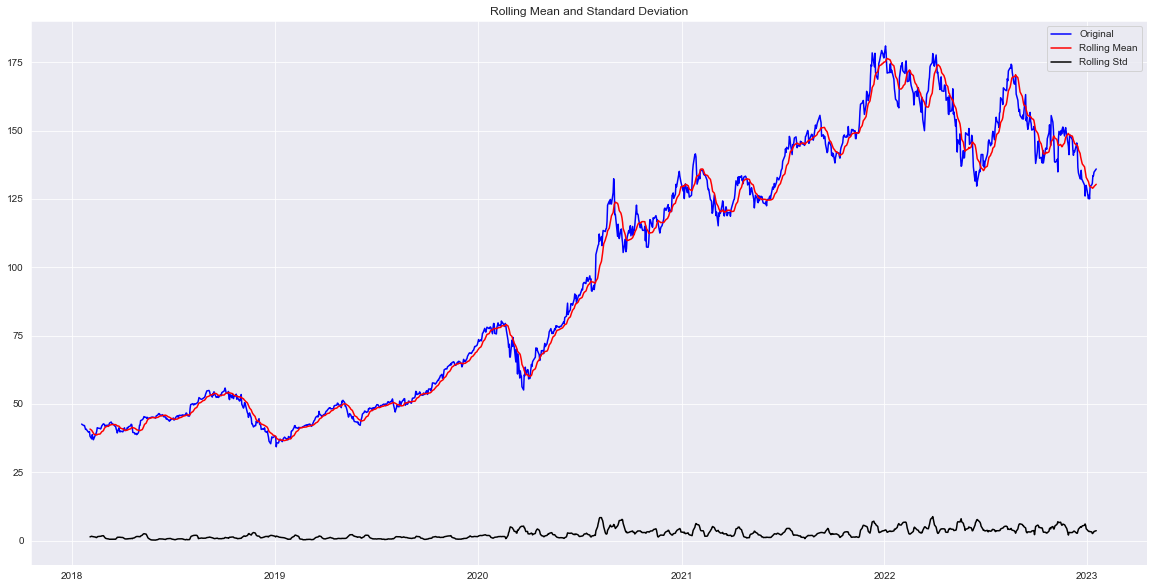

Results of dickey fuller test
Test Statistics                  -1.097703
p-value                           0.715987
No. of lags used                 11.000000
Number of observations used    1246.000000
Critical value 1%                -3.435609
Critical value 5%                -2.863862
Critical value 10%               -2.568006
dtype: float64


In [7]:
test_adf(data['Adj Close'])

In [8]:
data_adj_close = data['Adj Close'].tolist()

<Figure size 432x288 with 0 Axes>

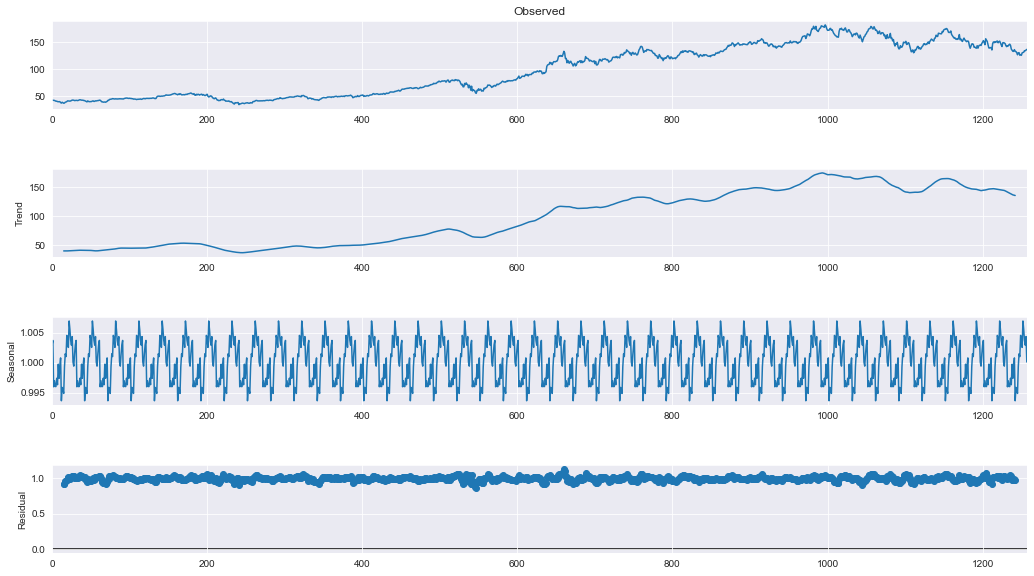

In [9]:
result = seasonal_decompose(data_adj_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)

# Converting non-stationary to stationary data

In [10]:
data_adj_close_log = np.log(data_adj_close)
df_data_adj_close_log = pd.DataFrame({'Adj_Close': data_adj_close_log})
moving_average = df_data_adj_close_log.rolling(12).mean()
std_dev = df_data_adj_close_log.rolling(12).std()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


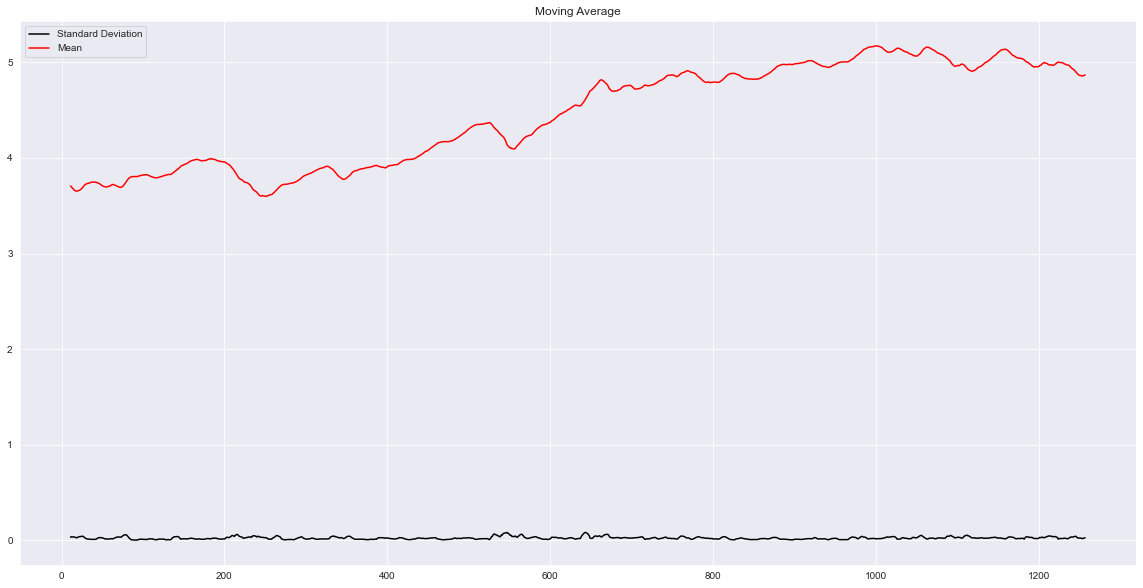

In [11]:
rcParams['figure.figsize'] = 20, 10
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_average, color='red', label='Mean')
plt.legend()
plt.show()

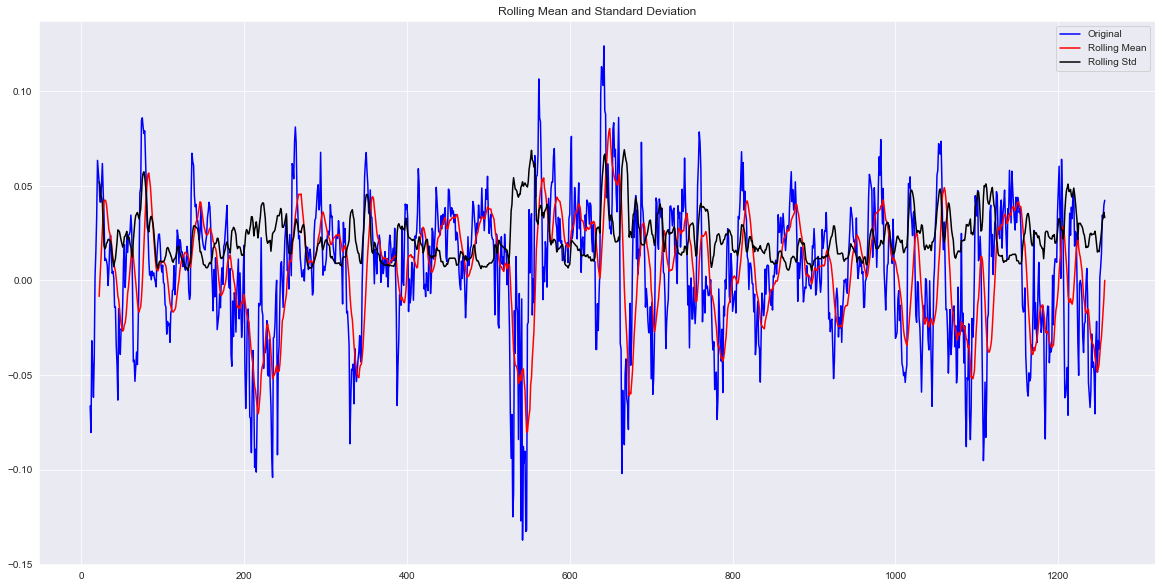

Results of dickey fuller test
Test Statistics               -6.986608e+00
p-value                        7.938971e-10
No. of lags used               1.100000e+01
Number of observations used    1.235000e+03
Critical value 1%             -3.435656e+00
Critical value 5%             -2.863883e+00
Critical value 10%            -2.568018e+00
dtype: float64


In [12]:
data_log_minus_mean = df_data_adj_close_log - moving_average
data_log_minus_mean.dropna(inplace=True)
test_adf(data_log_minus_mean)

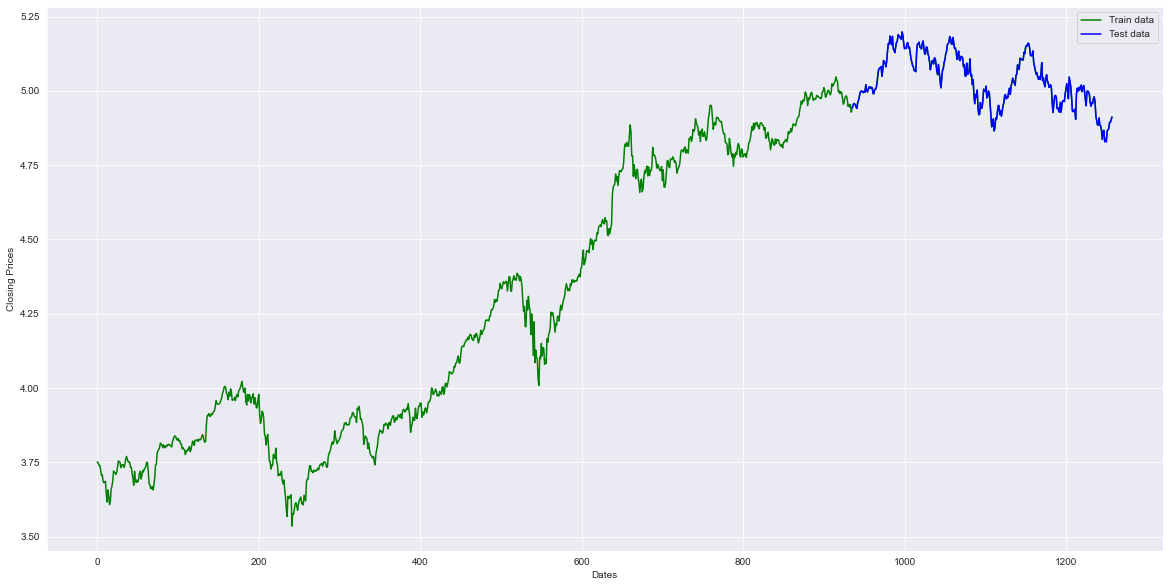

In [13]:
train_data, test_data = (df_data_adj_close_log[:int(len(data_adj_close_log)*0.75)], 
                         df_data_adj_close_log[int(len(data_log_minus_mean)*0.75):])
plt.figure(figsize=(20, 10))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data_adj_close_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [14]:
train_data

,Adj_Close
0,3.752196
1,3.747723
2,3.739509
3,3.739734
4,3.723678
...,...
938,4.954900
939,4.954270
940,4.945125
941,4.940876


In [15]:
test_data

,Adj_Close
935,4.942294
936,4.948582
937,4.957625
938,4.954900
939,4.954270
...,...
1253,4.873134
1254,4.894027
1255,4.893427
1256,4.903495


# Auto ARIMA

In [16]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                                test='adf', max_p=7, max_q=7, m=1,
                                d=None, seasonal=False, start_P=0,
                                D=0, trace=True, error_action='ignore',
                                suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4592.856, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4610.785, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4609.817, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4591.376, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4609.045, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4609.081, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4606.794, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4608.161, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.753 seconds


# ARIMA

In [17]:
model = ARIMA(train_data, order=(1, 1, 0))
fitted = model.fit()

In [20]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj_Close   No. Observations:                  943
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2306.081
Date:                Wed, 18 Jan 2023   AIC                          -4608.161
Time:                        04:11:31   BIC                          -4598.465
Sample:                             0   HQIC                         -4604.465
                                - 943                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1407      0.020     -7.008      0.000      -0.180      -0.101
sigma2         0.0004   1.13e-05     38.801      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1065.53
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.41
Prob(H) (two-sided):                  0.21   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
dfdf = fitted.get_forecast(test_data.shape[0], alpha=0.05).summary_frame()
dfdf

Adj_Close,mean,mean_se,mean_ci_lower,mean_ci_upper
943,4.958083,0.020917,4.917087,4.999080
944,4.958479,0.027579,4.904425,5.012534
945,4.958424,0.033148,4.893456,5.023392
946,4.958432,0.037878,4.884191,5.032672
947,4.958430,0.042084,4.875947,5.040914
...,...,...,...,...
1261,4.958431,0.327659,4.316231,5.600630
1262,4.958431,0.328172,4.315226,5.601635
1263,4.958431,0.328683,4.314223,5.602638
1264,4.958431,0.329195,4.313221,5.603640


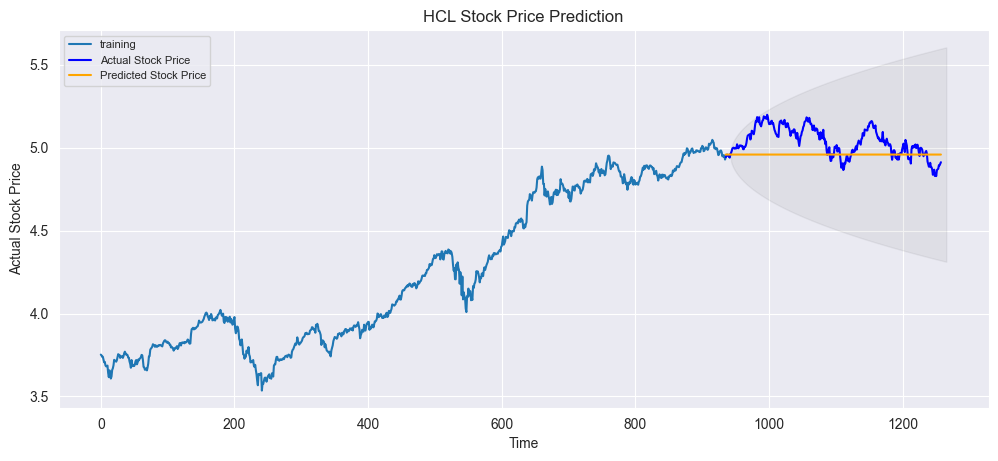

In [44]:
fc = fitted.get_forecast(test_data.shape[0], alpha=0.05)
conf = fc.conf_int()
summary = fc.summary_frame()
fc_series = pd.Series(summary['mean'].tolist(), index=test_data.index)
lower_series = pd.Series(summary['mean_ci_lower'].tolist(), index=test_data.index)
upper_series = pd.Series(summary['mean_ci_upper'].tolist(), index=test_data.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(summary.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('HCL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()